In [1]:
%reload_ext autoreload
%autoreload 2

import os
import io
import datetime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
)

import numpy as np

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Nopep8

import matplotlib.pyplot as plt

## S3

In [2]:
s3 = boto3.client("s3")

s3_bucket = "yang-ml-sagemaker"
s3_key = "lesion-segmentation"

train_val_path = {
    "train": f"s3://{s3_bucket}/{s3_key}/input-data/train",
    "val": f"s3://{s3_bucket}/{s3_key}/input-data/val",
}
train_val_path

{'train': 's3://yang-ml-sagemaker/lesion-segmentation/input-data/train',
 'val': 's3://yang-ml-sagemaker/lesion-segmentation/input-data/val'}

## Sagemaker

In [6]:
sagemaker_session = sagemaker.Session(default_bucket=s3_bucket)
sagemaker_session
sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()
s3_uploader = sagemaker.s3.S3Uploader()
instance_type = "ml.c5.9xlarge"
instance_count = 1

src_dir_path = os.path.join(os.path.dirname(os.getcwd()), "src")
hpo_script_path = "hpo_entry.py"
volume_size = 30
model_dir = "/opt/ml/model"
output_path = f"s3://{s3_bucket}/{s3_key}/models"
code_location = f"s3://{s3_bucket}/{s3_key}/code"

checkpoint_s3_uri = f"s3://{s3_bucket}/{s3_key}/checkpoints"
use_spot_instances = True
max_run = 86400
max_retry_attempts = 2

PY_VERSION = "py39"
FRAMEWORK_VERSION = (
    "2.8"  # Avoid bug with regards to data augmentation in tf 2.9 - 2.12
)

# Get today's date in YYYYMMDD format
today = datetime.datetime.today().strftime("%Y-%m-%d")

# Define endpoint name with version and date
endpoint_name = f"lesion-segmentation-{today}"

## Tensorflow Estimator

In [97]:
tf_estimator = TensorFlow(
    entry_point=hpo_script_path,
    source_dir=src_dir_path,
    role=role,
    py_version=PY_VERSION,
    framework_version=FRAMEWORK_VERSION,
    volume_size=volume_size,
    model_dir=model_dir,
    output_path=output_path,
    code_location=output_path,
    instance_type=instance_type,
    instance_count=instance_count,
    # Spot training
    max_run=max_run,
    max_wait=max_run,
    max_retry_attempts=max_retry_attempts,
    use_spot_instances=use_spot_instances,
    checkpoint_s3_uri=checkpoint_s3_uri,
)
tf_estimator

## Hyperparameter Tuning

In [98]:
search_space = {
    # Data augmentation
    "random_contrast_factor": ContinuousParameter(min_value=0.1, max_value=1.0),
    "random_flip_mode": CategoricalParameter(
        values=["horizontal", "vertical", "horizontal_and_vertical"]
    ),
    "random_rotation_factor": ContinuousParameter(min_value=0.1, max_value=0.5),
    "random_zoom_factor": ContinuousParameter(min_value=0.1, max_value=0.5),
    # Unet entry block
    "entry_block_batch_norm_momentum": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    # Encoder
    "down_sample_kernel_size_0": IntegerParameter(min_value=1, max_value=3),
    "down_sample_kernel_size_1": IntegerParameter(min_value=1, max_value=3),
    "down_sample_kernel_size_2": IntegerParameter(min_value=1, max_value=3),
    "down_sample_batch_norm_momentum_0": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    "down_sample_batch_norm_momentum_1": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    "down_sample_batch_norm_momentum_2": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    "down_sample_pool_size_0": IntegerParameter(min_value=1, max_value=2),
    "down_sample_pool_size_1": IntegerParameter(min_value=1, max_value=2),
    "down_sample_pool_size_2": IntegerParameter(min_value=1, max_value=2),
    # Decoder
    "up_sample_kernel_size_0": IntegerParameter(min_value=1, max_value=3),
    "up_sample_kernel_size_1": IntegerParameter(min_value=1, max_value=3),
    "up_sample_kernel_size_2": IntegerParameter(min_value=1, max_value=3),
    "up_sample_kernel_size_3": IntegerParameter(min_value=1, max_value=3),
    "up_sample_batch_norm_momentum_0": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    "up_sample_batch_norm_momentum_1": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    "up_sample_batch_norm_momentum_2": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    "up_sample_batch_norm_momentum_3": ContinuousParameter(
        min_value=0.65, max_value=0.99
    ),
    # Optimization
    "learning_rate": ContinuousParameter(
        min_value=1e-5, max_value=1e-2, scaling_type="Logarithmic"
    ),
    "clipnorm": ContinuousParameter(min_value=0.2, max_value=1.0),
    "batch_size": CategoricalParameter(values=[64, 128, 256]),
    "epochs": IntegerParameter(min_value=10, max_value=15),
}

objective_metric_name = "dice_loss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": objective_metric_name,
        "Regex": "Best validation dice loss: ([0-9\\.]+)",
    }
]
base_tuning_job_name = f"segmentation-hpo-job-{today}"

In [99]:
hpo_tuner = HyperparameterTuner(
    estimator=tf_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=search_space,
    metric_definitions=metric_definitions,
    strategy="Bayesian",
    objective_type=objective_type,
    max_jobs=25,
    max_parallel_jobs=5,
    base_tuning_job_name=base_tuning_job_name,
)

In [100]:
hpo_tuner.fit(train_val_path)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Hyperparmeter tuning results:

In [102]:
hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(
    hpo_tuner.latest_tuning_job.name
)

hpo_results = hpo_analytics.dataframe()

hpo_results.sort_values("FinalObjectiveValue", ascending=True).head(10)

,batch_size,clipnorm,down_sample_batch_norm_momentum_0,down_sample_batch_norm_momentum_1,down_sample_batch_norm_momentum_2,down_sample_kernel_size_0,down_sample_kernel_size_1,down_sample_kernel_size_2,down_sample_pool_size_0,down_sample_pool_size_1,...,up_sample_kernel_size_0,up_sample_kernel_size_1,up_sample_kernel_size_2,up_sample_kernel_size_3,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
6,"""64""",0.843176,0.744521,0.877674,0.968981,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,3.0,1.0,segmentation-hpo-job-230520-0050-019-27d9aa0c,Completed,0.733966,2023-05-20 01:37:57+00:00,2023-05-20 01:50:22+00:00,745.0
1,"""128""",0.834508,0.686794,0.906848,0.846651,3.0,3.0,1.0,2.0,1.0,...,1.0,2.0,3.0,2.0,segmentation-hpo-job-230520-0050-024-678adc82,Completed,0.737552,2023-05-20 01:50:52+00:00,2023-05-20 02:04:22+00:00,810.0
15,"""64""",0.869074,0.702733,0.954632,0.686983,2.0,2.0,1.0,2.0,1.0,...,3.0,1.0,2.0,3.0,segmentation-hpo-job-230520-0050-010-e29d9415,Completed,0.743932,2023-05-20 01:11:15+00:00,2023-05-20 01:27:00+00:00,945.0
7,"""64""",0.527239,0.752515,0.653418,0.882159,1.0,2.0,2.0,1.0,1.0,...,2.0,3.0,3.0,3.0,segmentation-hpo-job-230520-0050-018-d054d18e,Completed,0.754152,2023-05-20 01:37:13+00:00,2023-05-20 01:52:28+00:00,915.0
10,"""64""",0.723829,0.740954,0.676124,0.922166,3.0,2.0,1.0,1.0,2.0,...,2.0,2.0,3.0,1.0,segmentation-hpo-job-230520-0050-015-571b0204,Completed,0.765602,2023-05-20 01:28:39+00:00,2023-05-20 01:41:03+00:00,744.0
14,"""64""",0.495874,0.945074,0.804917,0.940631,1.0,2.0,1.0,2.0,2.0,...,2.0,3.0,1.0,1.0,segmentation-hpo-job-230520-0050-011-c8777167,Completed,0.769777,2023-05-20 01:17:57+00:00,2023-05-20 01:29:11+00:00,674.0
24,"""64""",0.504934,0.966223,0.697460,0.957780,1.0,2.0,1.0,2.0,2.0,...,2.0,3.0,1.0,1.0,segmentation-hpo-job-230520-0050-001-340d3095,Completed,0.777155,2023-05-20 00:51:31+00:00,2023-05-20 01:08:06+00:00,995.0
16,"""64""",0.522979,0.977561,0.709382,0.889957,1.0,2.0,1.0,2.0,2.0,...,1.0,2.0,2.0,3.0,segmentation-hpo-job-230520-0050-009-81be966e,Completed,0.806711,2023-05-20 01:11:13+00:00,2023-05-20 01:27:03+00:00,950.0
20,"""128""",0.591797,0.722503,0.876725,0.715631,3.0,1.0,3.0,2.0,1.0,...,1.0,3.0,3.0,3.0,segmentation-hpo-job-230520-0050-005-5ebb2b35,Completed,0.815036,2023-05-20 00:51:35+00:00,2023-05-20 01:10:16+00:00,1121.0
8,"""64""",0.612743,0.665581,0.820668,0.687999,1.0,2.0,3.0,2.0,2.0,...,3.0,3.0,2.0,2.0,segmentation-hpo-job-230520-0050-017-fa34b319,Completed,0.837343,2023-05-20 01:30:30+00:00,2023-05-20 01:46:56+00:00,986.0


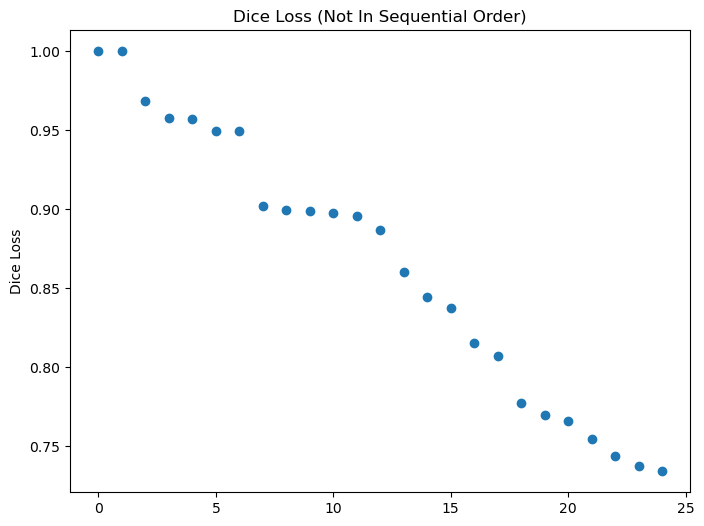

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    range(hpo_results.shape[0]),
    hpo_results.sort_values("FinalObjectiveValue", ascending=False)[
        "FinalObjectiveValue"
    ],
)
plt.title("Dice Loss (Not In Sequential Order)")
plt.ylabel("Dice Loss")
plt.show();

## Deploy Best Model

In [8]:
# Obtain the name of best training job
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hpo_tuner.latest_tuning_job.name
)["BestTrainingJob"]["TrainingJobName"]

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(TrainingJobName=best_model_name)[
    "ModelArtifacts"
]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path}")

Best model artifacts persisted at s3://yang-ml-sagemaker/lesion-segmentation/model/segmentation-hpo-job-230520-0050-019-27d9aa0c/output/model.tar.gz


In [9]:
best_model = TensorFlowModel(
    model_data=best_model_s3_path, role=role, framework_version=FRAMEWORK_VERSION
)

predictor = best_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.4xlarge",
    endpoint_name=endpoint_name + "-v1",
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

## Inference on Test Set

In [10]:
test_images = np.load(
    io.BytesIO(
        s3.get_object(
            Bucket=s3_bucket, Key=f"{s3_key}/input-data/test/test_images.npy"
        )["Body"].read()
    )
)
test_masks = np.load(
    io.BytesIO(
        s3.get_object(Bucket=s3_bucket, Key=f"{s3_key}/input-data/test/test_masks.npy")[
            "Body"
        ].read()
    )
)

test_images.shape, test_masks.shape

((546, 256, 256, 1), (546, 256, 256, 1))

Randomly predict 10 instances in the test set:

In [52]:
# Take a sample of 10 test images
random_indices = np.random.randint(low=0, high=test_images.shape[0], size=10)

predictions = predictor.predict(test_images[random_indices])
# A list of lists
predictions = predictions["predictions"]
# Convert each list to numpy array and add new axis (first dimension)
predictions = [np.array(pred)[np.newaxis, :, :, :] for pred in predictions]
predictions = np.vstack(predictions)

predictions.shape

(10, 256, 256, 1)

### Visual Inspection of Segmentation Quality

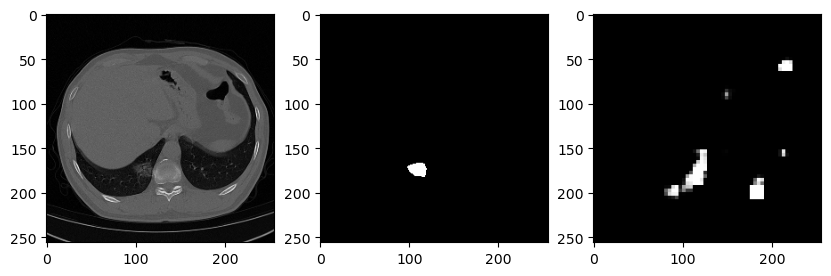

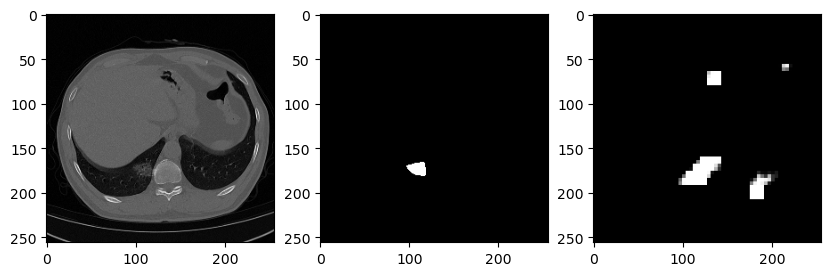

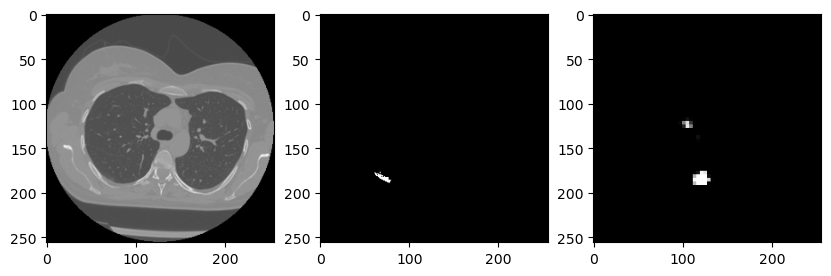

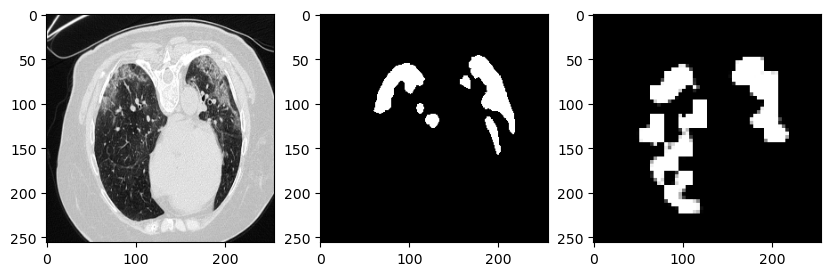

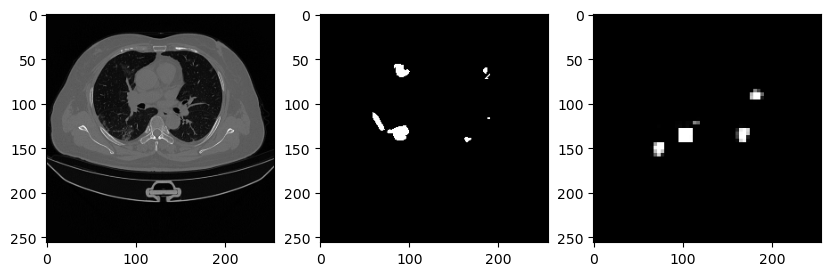

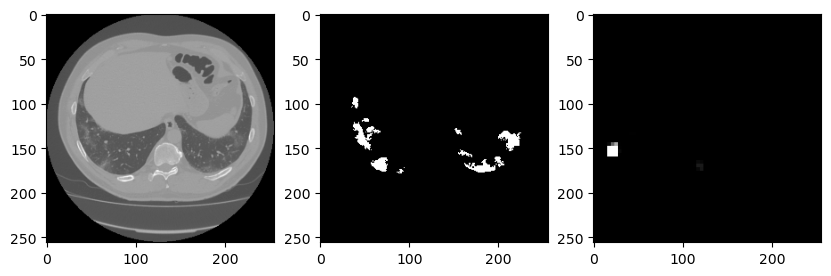

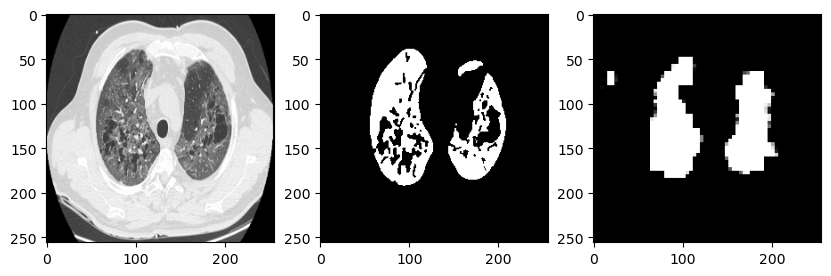

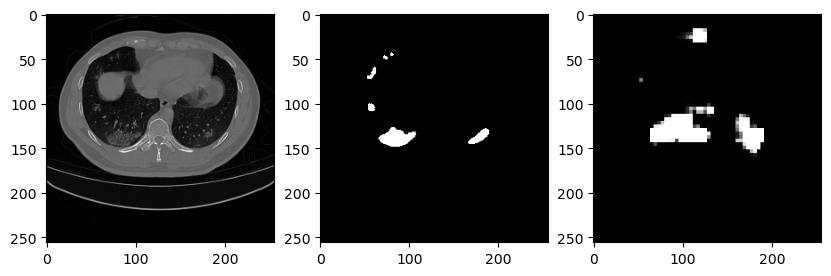

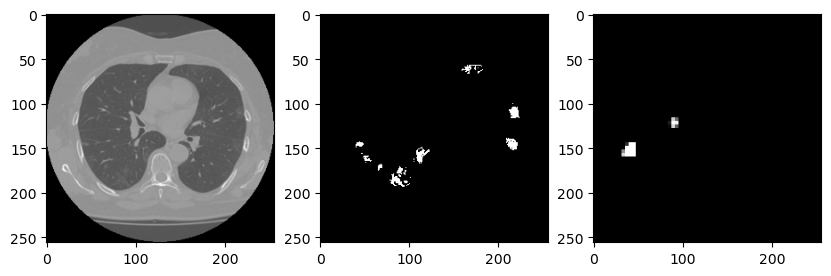

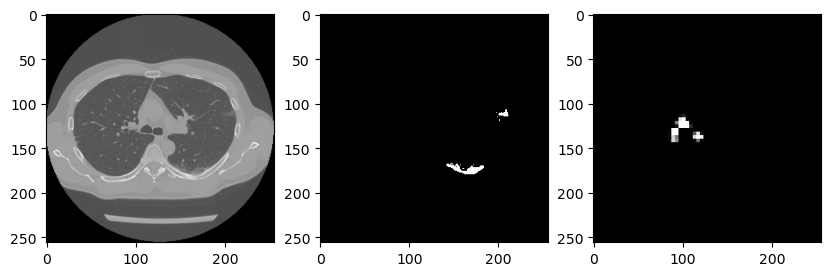

In [53]:
for i, indx in enumerate(random_indices):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

    img = axes[0]
    img.imshow(test_images[indx], cmap="gray")

    true_mask = axes[1]
    true_mask.imshow(test_masks[indx], cmap="gray")

    pred_mask = axes[2]
    pred_mask.imshow(predictions[i], cmap="gray")

The results are expectedly suboptimal, likely due to overfitting, which is the number one concern for small datasets. 

## Clean-up

In [54]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': '39091255-9368-47c5-866e-155c659ef98f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '39091255-9368-47c5-866e-155c659ef98f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 20 May 2023 06:10:00 GMT'},
  'RetryAttempts': 0}}

In [55]:
sm_boto3.close()